# Big Shadow State Tomography

In [1]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_gate_map 

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2
from qiskit_ibm_runtime.fake_provider import FakeKyiv

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd -q ../..

from rivet_transpiler import transpile_right

In [2]:
FAKE_BACKEND = FakeKyiv()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

#### 3.3. Functions

In [3]:
def get_ghz_circuit(qubits_count):

    qubits = list(range(qubits_count))

    circuit = qiskit.QuantumCircuit(qubits_count)

    circuit.h(0)

    for control, target in zip(qubits, qubits[1:]):

        circuit.cx(control, target)

    return circuit

In [4]:
def rotate_qubit_to_basis(circuit, qubit, basis):

    if basis == "X":
        circuit.h(qubit)

    elif basis == "Y":
        circuit.sdg(qubit)
        circuit.h(qubit)

    elif basis == "Z":
        pass

In [5]:
def build_bases_rotation_circuit(bases):

    qubits_count = len(bases)

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit, basis in enumerate(bases):

        if basis == "X":
            circuit.h(qubit)

        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)

        elif basis == "Z":
            pass

    return circuit

In [6]:
def get_inverted_channel(channel, qubits_count):

    identity = np.eye(2 ** qubits_count)

    inverted_channel = (2 ** qubits_count + 1) * channel - identity

    return inverted_channel

In [7]:
def get_basis_unitary(basis):

    if basis == "X":
        unitary = 1/np.sqrt(2) * np.array([[1.,1.],
                                           [1.,-1.]])
    elif basis == "Y":
        unitary = 1/np.sqrt(2) * np.array([[1.,-1.0j],
                                           [1.,1.j]])
    elif basis == "Z":
        unitary = np.eye(2)

    return unitary

In [8]:
def get_mean_square_error(a, b):

    mean_square_error = np.abs(((a - b) ** 2).mean())

    return mean_square_error

### Circuit

In [86]:
QUBITS_COUNT = 5
SU2_LAYERS_COUNT = 10
PARAMETRIZATION_RATIO = 0.25

OPTIMIZATION_LEVEL = 3

SEED = 1234

In [87]:
qubits = list(range(QUBITS_COUNT))

rng = np.random.default_rng(SEED) 

#### 4.1.2.  Parametrized SU2 Circuit

In [88]:
# Non-Parametrized Part

left_part = qiskit.QuantumCircuit(QUBITS_COUNT)
right_part = qiskit.QuantumCircuit(QUBITS_COUNT)

non_parametrized_layers_count = SU2_LAYERS_COUNT * 2 * (1 / PARAMETRIZATION_RATIO - 1)

non_parametrized_layers_count = int(non_parametrized_layers_count)

for left_layer in range(non_parametrized_layers_count // 2):
    left_part.rz(0.5, qubits)
    
for right_layer in range(non_parametrized_layers_count // 2):
    right_part.rz(1.5, qubits)   
    
# Parametrized Part

parametrized_part = qiskit.circuit.library.EfficientSU2(
    num_qubits=QUBITS_COUNT,
    reps=SU2_LAYERS_COUNT,
    entanglement="linear",
    skip_final_rotation_layer=True
)

# Compose Parts

parametrized_part = parametrized_part.decompose()

parametrized_circuit = parametrized_part.compose(left_part, front=True)
parametrized_circuit = parametrized_circuit.compose(right_part)

# Bind Parameters

random_parameters = np.random.rand(parametrized_circuit.num_parameters)

circuit = parametrized_circuit.assign_parameters(random_parameters)

print("circuit.depth():", circuit.depth())

circuit.draw(fold=-1)

circuit.depth(): 102


┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐ ┌────────────┐┌─────────────┐      ┌─────────────┐┌─────────────┐                              ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐                               ┌─────────────┐┌─────────────┐                              ┌─────────────┐┌─────────────┐                              ┌─────────────┐┌─────────────┐                              ┌─────────────┐┌─────────────┐                              ┌─────────────┐ ┌──────────────┐                                ┌─────────┐  ┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐                                 
q_0: ┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├─┤ Ry(0.7094) ├┤ Rz(0.17974) ├───■──┤ Ry(0.74761) ├┤ Rz(0.36895) ├──────────────────────■───────┤ Ry(0.48081) ├┤ Rz(0.57173) ├───────────────────────■───────┤ Ry(0.36357) ├┤ Rz(0.86203) ├───────────────────────■───────┤ Ry(0.50118) ├┤ Rz(0.11564) ├──────────────────────■────────┤ Ry(0.28811) ├┤ Rz(0.12774) ├──────────────────────■───────┤ Ry(0.13391) ├┤ Rz(0.69121) ├──────────────────────■───────┤ Ry(0.71201) ├┤ Rz(0.97343) ├──────────────────────■───────┤ Ry(0.66462) ├┤ Rz(0.59158) ├──────────────────────■───────┤ Ry(0.99011) ├─┤ Rz(0.055613) ├──────────────────────■─────────┤ Rz(1.5) ├──┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├┤ Rz(1.5) ├─────────────────────────────────
     ├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤┌┴────────────┤├─────────────┤ ┌─┴─┐└─────────────┘├─────────────┤┌─────────────┐     ┌─┴─┐     └─────────────┘├─────────────┤┌─────────────┐      ┌─┴─┐     └─────────────┘├─────────────┤┌─────────────┐      ┌─┴─┐     └─────────────┘├─────────────┤┌─────────────┐     ┌─┴─┐      └─────────────┘└┬────────────┤┌─────────────┐     ┌─┴─┐     └─────────────┘├─────────────┤ ┌────────────┐     ┌─┴─┐     └─────────────┘├─────────────┤┌─────────────┐     ┌─┴─┐     └─────────────┘├─────────────┤┌─────────────┐     ┌─┴─┐     └─────────────┘ ├─────────────┬┘┌─────────────┐     ┌─┴─┐       └─────────┘  ├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤├─────────┤┌─────────┐                      
q_1: ┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(0.5) ├┤ Rz(

#### Other Circuits

In [89]:
## GHZ Circuit

circuit = get_ghz_circuit(QUBITS_COUNT)
circuit.draw(fold=-1)

## Random Circuit

# circuit = random_circuit(QUBITS_COUNT, depth=20, max_operands=1, measure=False)

┌───┐                    
q_0: ┤ H ├──■─────────────────
     └───┘┌─┴─┐               
q_1: ─────┤ X ├──■────────────
          └───┘┌─┴─┐          
q_2: ──────────┤ X ├──■───────
               └───┘┌─┴─┐     
q_3: ───────────────┤ X ├──■──
                    └───┘┌─┴─┐
q_4: ────────────────────┤ X ├
                         └───┘

### 4.2.  Run Paulis Experiment

In [90]:
TOTAL_SHOTS_COUNT = 10000

In [91]:
random_bases = rng.choice(['X','Y','Z'], size=(TOTAL_SHOTS_COUNT, QUBITS_COUNT))

bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(243, 5)

In [92]:
rotation_circuits = []

for bases in bases_list:

    rotation_circuit = build_bases_rotation_circuit(bases)

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

243

#### Basic Transpilation - Slower Version!


In [93]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 243/243 [00:21<00:00, 11.08 basis/s]

estimated_time: 21.94


#### Transpile Right - Much Faster!

In [94]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 243/243 [00:06<00:00, 39.32 basis/s]

estimated_time: 6.28


In [95]:
shadow_circuits[0].draw(idle_wires=False, fold=-1)

global phase: 0
           ┌──────────┐┌────┐ ┌────────────┐                                                                                                                                                                                                                                ┌──────┐ ┌────────────┐┌────┐  ┌─────────┐   ┌─────────┐┌────┐┌─────────┐ ░             ┌─┐
q_4 -> 116 ┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-2.107) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(2.6054) ├┤ √X ├──┤ Rz(π/2) ├───┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────┤M├
           ├─────────┬┘├────┤┌┴────────────┤                                                                                                                                                           ┌──────┐ ┌────────────┐┌────┐┌──────────────┐   ┌────┐  ┌─────────┐  │  Ecr │ └┬──────────┬┘├────┤┌─┴─────────┴──┐├─────────┤├────┤├─────────┤ ░          ┌─┐└╥┘
q_3 -> 117 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-2.2219) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(2.4904) ├┤ √X ├┤ Rz(-0.21809) ├───┤ √X ├──┤ Rz(π/2) ├──┤1     ├──┤ Rz(-π/2) ├─┤ √X ├┤ Rz(-0.21809) ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░──────────┤M├─╫─
           ├─────────┤ ├────┤├─────────────┤                                                                                      ┌──────┐ ┌────────────┐┌────┐┌─────────────┐   ┌────┐  ┌──────────┐  │  Ecr │ └┬─────────┬─┘├────┤├─────────────┬┘┌──┴────┴─┐└──┬────┬─┘┌─┴──────┴┐ └──────────┘ └────┘└──────────────┘└─────────┘└────┘└─────────┘ ░       ┌─┐└╥┘ ║ 
q_2 -> 118 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-2.2219) ├──────────────────────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(2.4904) ├┤ √X ├┤ Rz(-2.9501) ├───┤ √X ├──┤ Rz(-π/2) ├──┤1     ├──┤ Rz(π/2) ├──┤ √X ├┤ Rz(-2.9501) ├─┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├─────────────────────────────────────────────────────────────────░───────┤M├─╫──╫─
           ├─────────┴┐├────┤├─────────────┤                 ┌──────┐┌─────────────┐┌────┐┌──────────────┐   ┌────┐  ┌─────────┐  │  Ecr │ └┬─────────┬─┘├────┤├─────────────┤┌──┴────┴─┐└──┬────┬──┘┌─┴──────┴┐ └─────────┘  └────┘└─────────────┘ └─────────┘   └────┘  └─────────┘                                                                 ░    ┌─┐└╥┘ ║  ║ 
q_1 -> 119 ┤ Rz(-π/2) ├┤ √X ├┤ Rz(-3.0124) ├─────────────────┤0     ├┤ Rz(-1.4416) ├┤ √X ├┤ Rz(-0.19154) ├───┤ √X ├──┤ Rz(π/2) ├──┤1     ├──┤ Rz(π/2) ├──┤ √X ├┤ Rz(-2.9501) ├┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────┤M├─╫──╫──╫─
           ├─────────┬┘├────┤├─────────────┤┌────┐┌─────────┐│  Ecr │└─┬─────────┬─┘├────┤└┬────────────┬┘┌──┴────┴─┐└──┬────┬─┘┌─┴──────┴┐ └─────────┘  └────┘└─────────────┘└─────────┘   └────┘   └─────────┘                                                                                                                                      ░ ┌─┐└╥┘ ║  ║  ║ 
q_0 -> 120 ┤ Rz(π/2) ├─┤ √X ├┤ Rz(-0.8071) ├┤ √X ├┤ Rz(π/2) ├┤1     ├──┤ Rz(π/2) ├──┤ √X ├─┤ Rz(0.8071) ├─┤ Rz(π/2) ├───┤ √X ├──┤ Rz(π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├─╫──╫──╫──╫─
           └─────────┘ └────┘└─────────────┘└────┘└─────────┘└──────┘  └─────────┘  └────┘ └────────────┘ └─────────┘   └────┘  └─────────┘                                                                                                                                                                                                           ░ └╥┘ ║  ║  ║  ║ 
   meas: 5/═════════════

#### Run Shadow Circuits

In [96]:
counts_list = []

for shadow_circuit, shots in zip(shadow_circuits, shots_counts):

    job = backend.run(shadow_circuit, shots=shots)

    counts = job.result().get_counts()

    counts_list.append(counts)

#### Calculate Shadows

Calculate the shadow matrices for a set of observed states used to estimate the quantum state of the system.

In [97]:
shadows = []

for bases, counts in zip(bases_list, counts_list):

    for state, count in counts.items():

        shadow_part = 1

        for bit_index, bit in enumerate(state[::-1]):

            basis = bases[bit_index]

            basis_unitary = get_basis_unitary(basis)

            vector = basis_unitary[int(bit), :]

            outer_product = np.outer(vector.conj(), vector)

            inverted_channel = get_inverted_channel(outer_product, 1)

            shadow_part = np.kron(inverted_channel, shadow_part)

        shadow = shadow_part * count

        shadows.append(shadow)

#### Analyze Density Matrices

In [98]:
reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(32, 32)

In [99]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(32, 32)

In [100]:
def plot_density_matrix(density_matrix, label=""):

    plt.suptitle(f"{label} Density Matrix", y=0.9)

    real = plt.subplot(121)
    real.set_title("Real part")

    real.imshow(density_matrix.real, vmin=-0.7, vmax=0.7)

    real.axes.set_xticks(())
    real.axes.set_yticks(())


    imaginary = plt.subplot(122)
    imaginary.set_title("Imaginary part")
    imaginary.imshow(density_matrix.imag, vmin=-0.7, vmax=0.7)

    imaginary.axes.set_xticks(())
    imaginary.axes.set_yticks(())

    plt.show()

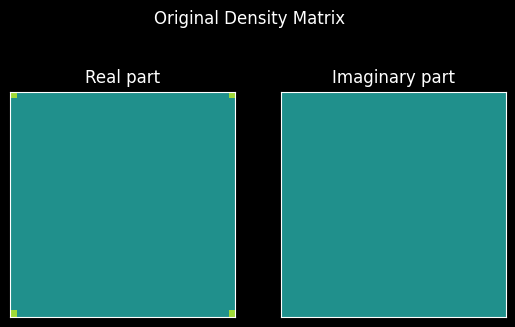

In [101]:
plot_density_matrix(original_density_matrix, label="Original")

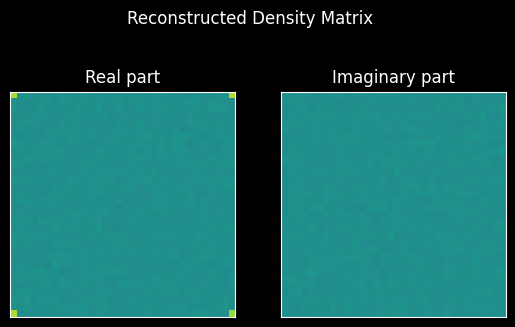

In [102]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

To measure a Mean Square Error:

In [103]:
mean_square_error = np.abs(((original_density_matrix -
                             reconstructed_density_matrix) ** 2).mean())

mean_square_error

8.780395507812223e-07